# Problem Statement

Ebuss in an e-commerce company which has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, we are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In [553]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

In [554]:
import nltk
nltk.download('punkt')
from nltk import FreqDist
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deepak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [555]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

In [556]:
from wordcloud import WordCloud
import swifter
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle

In [557]:
import spacy
#!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [558]:
from sklearn.metrics.pairwise import pairwise_distances

### Data sourcing and understanding

In [559]:
dfreviews=pd.read_csv('data/sample30.csv')
dfreviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [560]:
dfreviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [561]:
dfreviews.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [562]:
dfreviews.describe()

,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### Exploratory Data Analysis

In [563]:
dfreviews.brand.value_counts()

Clorox                   10585
Warner Home Video         3325
Disney                    1200
L'oreal Paris             1186
FOX                        887
                         ...  
Pacific Natural Foods        1
Noosa                        1
Southern Enterprises         1
SLOAN VALVE COMPANY          1
Universal Music              1
Name: brand, Length: 214, dtype: int64

In [564]:
dfreviews.manufacturer.value_counts()

Clorox                                8546
Test                                  3325
AmazonUs/CLOO7                        2039
L'oreal Paris                         1232
Walt Disney                           1143
                                      ... 
Pacific Foods of Oregon, Inc.            1
Unfi                                     1
Herr's                                   1
Southern Enterprises                     1
Universal Music Group / Cash Money       1
Name: manufacturer, Length: 227, dtype: int64

In [565]:
dfreviews.name.value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8545
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3325
Clorox Disinfecting Bathroom Cleaner                                              2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1143
                                                                                  ... 
5302050 15/16 FCT/HOSE ADAPTOR                                                       1
Clorox Ultimate Care Premium Bleach                                                  1
Pocket Watch Wall Clock Distressed Black - Yosemite Home Decor174                    1
Stonyfield Yobaby Peach & Pear Yogurt 4oz 6 Ct                                       1
Pink Friday: Roman Reloaded Re-Up (w/dvd)                                            1
Name: name, Length: 271, dtype: int64

<AxesSubplot:xlabel='reviews_didPurchase', ylabel='count'>

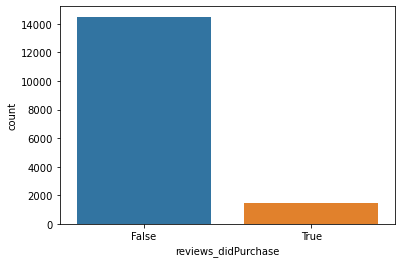

In [566]:
sns.countplot(data=dfreviews,x='reviews_didPurchase')

<AxesSubplot:xlabel='reviews_doRecommend', ylabel='count'>

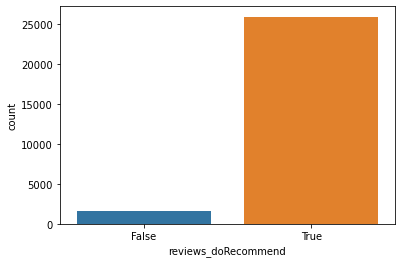

In [567]:
sns.countplot(data=dfreviews,x='reviews_doRecommend')

<AxesSubplot:xlabel='reviews_rating', ylabel='count'>

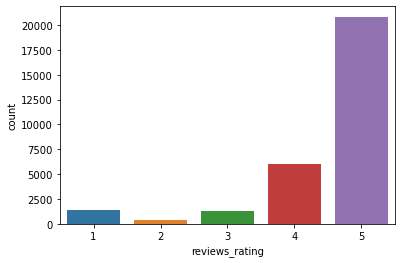

In [568]:
sns.countplot(data=dfreviews,x='reviews_rating')

In [569]:
dfreviews.reviews_title.value_counts()

Great Product                       384
Great movie                         361
Clorox Wipes                        278
Great                               221
Great product                       205
                                   ... 
Keeping them healthy!                 1
Fighting Power                        1
great all together                    1
Great Product and Easy to Use...      1
Conditioned into healthy              1
Name: reviews_title, Length: 18535, dtype: int64

In [570]:
dfreviews.reviews_username.value_counts()

mike                 41
byamazon customer    41
chris                32
lisa                 16
sandy                15
                     ..
nurse32               1
lisa62                1
bigal515              1
mom271                1
kcoopxoxo             1
Name: reviews_username, Length: 24914, dtype: int64

In [571]:
dfreviews.user_sentiment.unique()

array(['Positive', 'Negative', nan], dtype=object)

<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

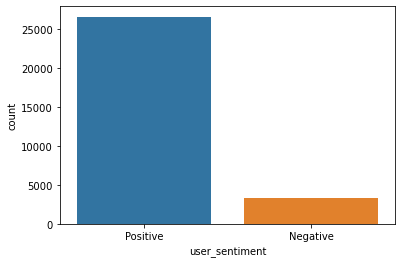

In [572]:
sns.countplot(data=dfreviews,x='user_sentiment')

<AxesSubplot:xlabel='reviews_rating', ylabel='percentage'>

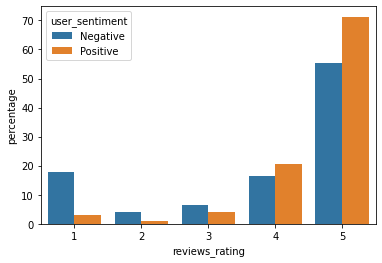

In [573]:
# Ratings distribution for each user sentiment
dfreviews_per_sent=((dfreviews.groupby(['user_sentiment','reviews_rating'])['id'].count()/dfreviews.groupby(['user_sentiment'])['reviews_rating'].count())*100).rename('percentage').reset_index()
sns.barplot(data=dfreviews_per_sent,x='reviews_rating',y='percentage',hue='user_sentiment')

In [574]:
# review text length
dfreviews.reviews_text.str.len().describe()

count    30000.000000
mean       183.056967
std        186.054147
min          2.000000
25%         83.000000
50%        131.000000
75%        217.000000
max       5865.000000
Name: reviews_text, dtype: float64

<AxesSubplot:xlabel='reviews_text', ylabel='Density'>

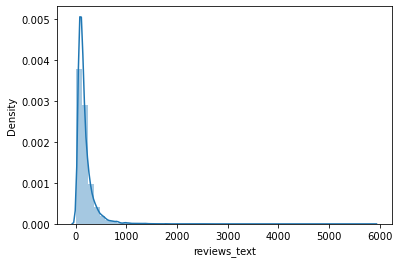

In [575]:
# review text length distribution
sns.distplot(dfreviews.reviews_text.str.len())

### Data Cleaning

In [576]:
# Map the user sentiment to a numerical value
dfreviews['user_sentiment']=dfreviews['user_sentiment'].map({'Positive':1,'Negative':0})
dfreviews.user_sentiment.unique()

array([ 1.,  0., nan])

In [577]:
# Combine the review title with the text
dfreviews['reviews_title_plus_text']=dfreviews['reviews_title'].fillna('')+'. '+dfreviews['reviews_text']

In [578]:
# Use columns which are relevant for sentiment analysis
dfSentiment=dfreviews[['id','name','reviews_title_plus_text','user_sentiment']]

In [579]:
# Remove rows where the user sentiment is not available
dfSentiment=dfSentiment[~dfSentiment.user_sentiment.isnull()].reset_index(drop=True)
dfSentiment.shape

(29999, 4)

In [580]:
dfSentiment.head()

,id,name,reviews_title_plus_text,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very goo...,1.0
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected a...,1.0
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1.0
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Disappointed. I read through the reviews on he...,0.0
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation. My husband bought this gel for us....,0.0


### Text Processing

In [581]:
# Function to clean the text and remove all the unnecessary elements.
def pre_process(text):
    text=text.lower() # text to lower-case
    text=text.strip() # remove leading and trailing spaces
    text=re.sub('[^\w\s]','',text) # remove punctutations
    return text

In [582]:
# Function to lemmatize the text
def apply_lemma(pre_processed_text):
    t=[]
    doc=nlp(pre_processed_text)
    for token in doc:
        if token.is_stop==False:
            #print(token.lemma_)
            t.append(token.lemma_)
    processed_text=' '.join(t)
    return processed_text

In [583]:
# create a column which has cleaned and lemmatized review text 
dfSentiment['reviews_processed']=dfSentiment.reviews_title_plus_text.swifter.apply(pre_process)
dfSentiment['reviews_processed']=dfSentiment.reviews_processed.swifter.apply(apply_lemma)

Pandas Apply:   0%|          | 0/29999 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/29999 [00:00<?, ?it/s]

In [584]:
dfSentiment.head()

,id,name,reviews_title_plus_text,user_sentiment,reviews_processed
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very goo...,1.0,awesome love album good hip hop current pop so...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected a...,1.0,good good flavor review collect promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1.0,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Disappointed. I read through the reviews on he...,0.0,disappointed read review look buy couple lubri...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation. My husband bought this gel for us....,0.0,irritation husband buy gel gel cause irritatio...


In [585]:
with open('data/dfSentiment.pk', 'wb') as fin:
    pickle.dump(dfSentiment, fin)

In [586]:
# Check frequent words in Negative ad Positive reviews
text_pos=str(dfSentiment[dfSentiment.user_sentiment==1]['reviews_processed'])
text_neg=str(dfSentiment[dfSentiment.user_sentiment==0]['reviews_processed'])

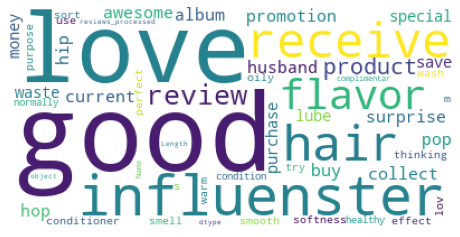

In [587]:
wordcloud = WordCloud(background_color ='white').generate(text_pos)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

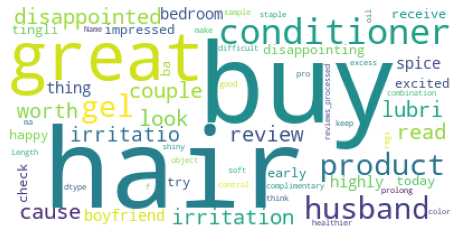

In [588]:
wordcloud = WordCloud(background_color ='white').generate(text_neg)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [589]:
# Find top 30 biagrams with positive sentiments
bigrams=[]
for s in dfSentiment[dfSentiment.user_sentiment==1]['reviews_processed']:
    bigrams.extend(nltk.bigrams(nltk.word_tokenize(s)))
most_common_bigrams=nltk.FreqDist(bigrams).most_common(30)
print(most_common_bigrams)

[(('review', 'collect'), 7942), (('collect', 'promotion'), 7942), (('clorox', 'wipe'), 2583), (('great', 'product'), 1905), (('great', 'movie'), 1684), (('easy', 'use'), 1541), (('love', 'clorox'), 1355), (('love', 'product'), 1173), (('good', 'movie'), 1035), (('smell', 'great'), 841), (('movie', 'great'), 832), (('love', 'love'), 815), (('disinfecting', 'wipe'), 772), (('work', 'great'), 707), (('love', 'wipe'), 682), (('product', 'love'), 668), (('love', 'movie'), 627), (('product', 'use'), 577), (('movie', 'good'), 574), (('product', 'great'), 546), (('godzilla', 'movie'), 543), (('wipe', 'love'), 538), (('good', 'product'), 535), (('use', 'clorox'), 532), (('receive', 'product'), 528), (('clorox', 'disinfecting'), 528), (('hair', 'feel'), 525), (('lip', 'shimmer'), 515), (('wipe', 'clean'), 452), (('clorox', 'product'), 446)]


In [590]:
# Find top 30 biagrams with negative sentiments
bigrams=[]
for s in dfSentiment[dfSentiment.user_sentiment==0]['reviews_processed']:
    bigrams.extend(nltk.bigrams(nltk.word_tokenize(s)))
most_common_bigrams=nltk.FreqDist(bigrams).most_common(30)
print(most_common_bigrams)

[(('review', 'collect'), 801), (('collect', 'promotion'), 801), (('clorox', 'wipe'), 260), (('old', 'formula'), 174), (('new', 'formula'), 163), (('bring', 'old'), 117), (('great', 'product'), 111), (('resident', 'evil'), 103), (('use', 'clorox'), 98), (('great', 'movie'), 68), (('use', 'product'), 67), (('product', 'use'), 67), (('lip', 'shimmer'), 65), (('use', 'wipe'), 63), (('love', 'clorox'), 60), (('exxtra', 'gel'), 59), (('new', 'product'), 58), (('love', 'product'), 56), (('wipe', 'use'), 54), (('not', 'like'), 52), (('good', 'product'), 48), (('disinfecting', 'wipe'), 48), (('new', 'gel'), 47), (('feel', 'like'), 45), (('bring', 'cocoa'), 45), (('will', 'not'), 44), (('change', 'formula'), 44), (('good', 'movie'), 44), (('clorox', 'product'), 43), (('love', 'movie'), 42)]


In [591]:
# Find top 30 biagrams with positive sentiments
trigrams=[]
for s in dfSentiment[dfSentiment.user_sentiment==1]['reviews_processed']:
    trigrams.extend(nltk.trigrams(nltk.word_tokenize(s)))
most_common_trigrams=nltk.FreqDist(trigrams).most_common(30)
print(most_common_trigrams)

[(('review', 'collect', 'promotion'), 7942), (('love', 'clorox', 'wipe'), 663), (('clorox', 'disinfecting', 'wipe'), 524), (('clean', 'review', 'collect'), 443), (('product', 'review', 'collect'), 402), (('use', 'clorox', 'wipe'), 290), (('great', 'product', 'love'), 287), (('use', 'review', 'collect'), 272), (('great', 'movie', 'great'), 261), (('opinion', 'review', 'collect'), 253), (('clorox', 'wipe', 'love'), 251), (('movie', 'great', 'movie'), 243), (('wipe', 'easy', 'use'), 236), (('receive', 'product', 'free'), 227), (('product', 'easy', 'use'), 217), (('love', 'love', 'love'), 216), (('great', 'review', 'collect'), 192), (('love', 'clorox', 'product'), 188), (('testing', 'purpose', 'opinion'), 182), (('great', 'product', 'great'), 181), (('wipe', 'review', 'collect'), 178), (('clorox', 'wipe', 'great'), 174), (('love', 'review', 'collect'), 171), (('clorox', 'wipe', 'easy'), 169), (('love', 'clorox', 'disinfecting'), 168), (('bring', 'old', 'formula'), 167), (('disinfect', 'rev

In [592]:
# Find top 30 biagrams with negative sentiments
trigrams=[]
for s in dfSentiment[dfSentiment.user_sentiment==0]['reviews_processed']:
    trigrams.extend(nltk.trigrams(nltk.word_tokenize(s)))
most_common_trigrams=nltk.FreqDist(trigrams).most_common(30)
print(most_common_trigrams)

[(('review', 'collect', 'promotion'), 801), (('bring', 'old', 'formula'), 74), (('use', 'clorox', 'wipe'), 65), (('use', 'review', 'collect'), 33), (('love', 'clorox', 'wipe'), 33), (('clorox', 'disinfecting', 'wipe'), 33), (('resident', 'evil', 'movie'), 32), (('cocoa', 'lip', 'shimmer'), 29), (('cold', 'flu', 'season'), 27), (('like', 'like', 'like'), 26), (('season', 'review', 'collect'), 25), (('product', 'review', 'collect'), 24), (('house', 'review', 'collect'), 24), (('great', 'product', 'use'), 21), (('clean', 'review', 'collect'), 19), (('nexxus', 'exxtra', 'gel'), 19), (('clorox', 'wipe', 'clean'), 18), (('wipe', 'review', 'collect'), 18), (('clorox', 'wipe', 'use'), 18), (('germ', 'review', 'collect'), 18), (('new', 'formula', 'horrible'), 17), (('flu', 'season', 'review'), 17), (('old', 'formula', 'new'), 17), (('home', 'review', 'collect'), 16), (('disinfect', 'review', 'collect'), 15), (('bathroom', 'review', 'collect'), 15), (('year', 'new', 'formula'), 15), (('clorox', 

### Feature extraction

In [593]:
X=dfSentiment['reviews_processed'].values
y=dfSentiment['user_sentiment'].values

In [594]:
#Write your code here to initialise the TfidfVectorizer 
tfidf=TfidfVectorizer(max_features=2000,ngram_range=(1,2),max_df=0.95,min_df=2)

In [595]:
X_tfidf = tfidf.fit_transform(X).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [596]:
feature_names = tfidf.get_feature_names()
len(feature_names)

2000

In [597]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y,random_state=100,train_size=0.8)

In [598]:
counter = Counter(y_train)
print(counter)

Counter({1.0: 21287, 0.0: 2712})


In [599]:
# Class imbalance can be seen as the positve sentiments are a lot more than negative sentiments
# Balance the class using smote
sm=SMOTE()
X_train, y_train=sm.fit_resample(X_train, y_train)

In [600]:
counter = Counter(y_train)
print(counter)

Counter({1.0: 21287, 0.0: 21287})


### Model Training

In [601]:
def print_metrics(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1score = f1_score(y, y_pred)
    #tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    #specificity = float(tn)/(tn+fp)
    print(f"Accuracy is : {accuracy*100:.1f}%")
    print(f"Precision is : {precision*100:.1f}%")
    print(f"Recall is : {recall*100:.1f}%")
    print(f"F1 Score is : {f1score*100:.1f}%")
    #print(f"Specificity is : {specificity*100:.1f}%")

def evaluate_model(clf, X_train, y_train, X_test, y_test):
    y_train_pred=clf.predict(X_train)
    print("#### Metrics on Train Data ####")
    print_metrics(y_train,y_train_pred)
    plot_confusion_matrix(clf, X_train, y_train)
    plt.show()

    y_test_pred=clf.predict(X_test)
    print('\n')
    print("#### Metrics on Test Data ####")
    print_metrics(y_test,y_test_pred)
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

#### Logistic Regression

In [602]:
lr = LogisticRegression(random_state=100)
lr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=100)

#### Metrics on Train Data ####
Accuracy is : 93.0%
Precision is : 94.2%
Recall is : 91.6%
F1 Score is : 92.9%


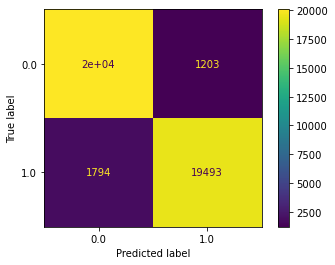



#### Metrics on Test Data ####
Accuracy is : 88.5%
Precision is : 96.2%
Recall is : 90.7%
F1 Score is : 93.3%


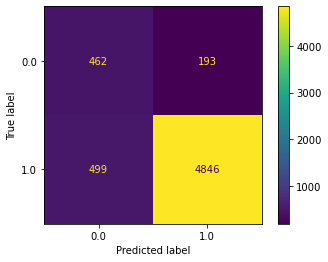

In [603]:
evaluate_model(lr, X_train, y_train, X_test, y_test)

#### Random Forest

In [604]:
rfc = RandomForestClassifier(random_state=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=100)

#### Metrics on Train Data ####
Accuracy is : 100.0%
Precision is : 100.0%
Recall is : 100.0%
F1 Score is : 100.0%


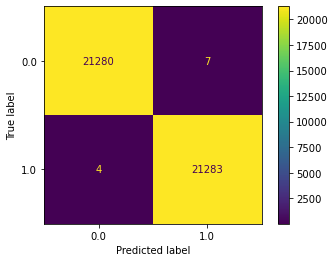



#### Metrics on Test Data ####
Accuracy is : 90.3%
Precision is : 94.0%
Recall is : 95.2%
F1 Score is : 94.6%


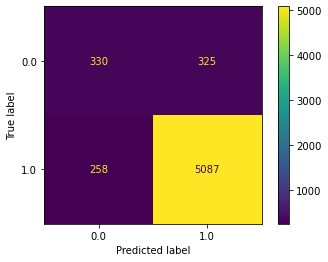

In [605]:
evaluate_model(rfc, X_train, y_train, X_test, y_test)

In [606]:
"""
# Hyperparameter tuning
parameters = {"n_estimators": range(100,500,100),
              "max_depth": range(2,7,1),
              "min_samples_split": [2, 6, 10],
              "min_samples_leaf": [1, 3, 4],
              "max_features":[i/10.0 for i in range(5,11)]}
rfc_random = RandomizedSearchCV(rfc, param_distributions = parameters,n_jobs=2,cv = 5,n_iter=20)
rfc_random.fit(X_train, y_train)
best_params_rfc = rfc_random.best_params_
print(rfc_random.best_score_)
"""

'\n# Hyperparameter tuning\nparameters = {"n_estimators": range(100,500,100),\n              "max_depth": range(2,7,1),\n              "min_samples_split": [2, 6, 10],\n              "min_samples_leaf": [1, 3, 4],\n              "max_features":[i/10.0 for i in range(5,11)]}\nrfc_random = RandomizedSearchCV(rfc, param_distributions = parameters,n_jobs=2,cv = 5,n_iter=20)\nrfc_random.fit(X_train, y_train)\nbest_params_rfc = rfc_random.best_params_\nprint(rfc_random.best_score_)\n'

In [607]:
"""
rfc_tuned = RandomForestClassifier(**best_params_rfc)
rfc_tuned.fit(X_train, y_train)
"""

'\nrfc_tuned = RandomForestClassifier(**best_params_rfc)\nrfc_tuned.fit(X_train, y_train)\n'

In [608]:
#evaluate_model(rfc_tuned, X_train, y_train, X_test, y_test)

#### XGBoost

In [609]:
xgbc = XGBClassifier(random_state=100)
xgbc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:14] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Metrics on Train Data ####
Accuracy is : 94.6%
Precision is : 95.8%
Recall is : 93.2%
F1 Score is : 94.5%


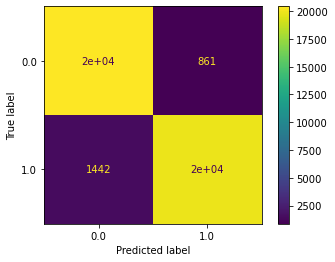



#### Metrics on Test Data ####
Accuracy is : 87.8%
Precision is : 95.5%
Recall is : 90.5%
F1 Score is : 93.0%


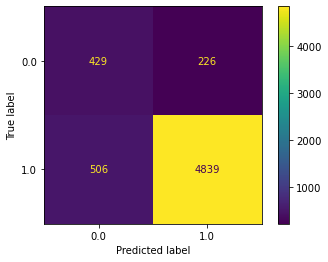

In [610]:
evaluate_model(xgbc, X_train, y_train, X_test, y_test)

In [611]:
xgbc.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 100,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [612]:
"""
# Hyperparameter tuning
parameters = {"learning_rate": [i/100.0 for i in range(2,12,2)],
              "n_estimators": range(100,800,100),
               "min_child_weight": range(1,5),
               "max_depth": range(2,7,1),
               "subsample":[i/10.0 for i in range(5,11)],
               "colsample_bytree":[i/10.0 for i in range(1,7)]}
xgbc_random = RandomizedSearchCV(xgbc, param_distributions = parameters,n_jobs=2,cv = 5,n_iter=20)
xgbc_random.fit(X_train, y_train)
best_params_xgbc = xgbc_random.best_params_
xgbc_random.best_score_
"""

'\n# Hyperparameter tuning\nparameters = {"learning_rate": [i/100.0 for i in range(2,12,2)],\n              "n_estimators": range(100,800,100),\n               "min_child_weight": range(1,5),\n               "max_depth": range(2,7,1),\n               "subsample":[i/10.0 for i in range(5,11)],\n               "colsample_bytree":[i/10.0 for i in range(1,7)]}\nxgbc_random = RandomizedSearchCV(xgbc, param_distributions = parameters,n_jobs=2,cv = 5,n_iter=20)\nxgbc_random.fit(X_train, y_train)\nbest_params_xgbc = xgbc_random.best_params_\nxgbc_random.best_score_\n'

In [613]:
"""
xgbc_tuned =XGBClassifierBClassifier(**best_params_xgbc)
xgbc_tuned.fit(X_train, y_train)
"""

'\nxgbc_tuned =XGBClassifierBClassifier(**best_params_xgbc)\nxgbc_tuned.fit(X_train, y_train)\n'

In [614]:
#evaluate_model(xgbc_tuned, X_train, y_train, X_test, y_test)

#### Naive Bayes

In [615]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

#### Metrics on Train Data ####
Accuracy is : 80.5%
Precision is : 79.3%
Recall is : 82.6%
F1 Score is : 80.9%


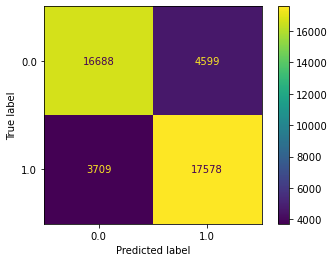



#### Metrics on Test Data ####
Accuracy is : 80.3%
Precision is : 95.2%
Recall is : 82.1%
F1 Score is : 88.2%


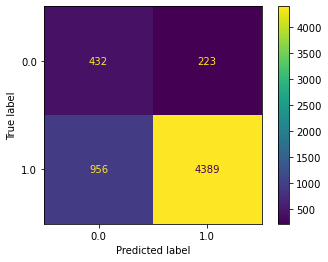

In [616]:
evaluate_model(mnb, X_train, y_train, X_test, y_test)

Random Forest Classifier gives the best metrics. Lets try the prediction on a sample text.

In [617]:
# Verify a sample positive feedback
X_sample = tfidf.transform(["Awesome product, will recommend"])
y_pred_sample = rfc.predict(X_sample)
y_pred_sample

array([1.])

In [618]:
# Verify a sample negative feedback
X_sample = tfidf.transform(["Bad product, quality is poor"])
y_pred_sample = rfc.predict(X_sample)
y_pred_sample

array([0.])

#### Save models

In [619]:
with open('models/rfc_model.pk', 'wb') as fin:
    pickle.dump(rfc, fin)

In [620]:
with open('models/tfidf_vectorizer.pk', 'wb') as fin:
    pickle.dump(tfidf, fin)

## Recommendation System

In [621]:
dfRecommendation = dfreviews[["id", "name", "reviews_rating", "reviews_username"]]
dfRecommendation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                30000 non-null  object
 1   name              30000 non-null  object
 2   reviews_rating    30000 non-null  int64 
 3   reviews_username  29937 non-null  object
dtypes: int64(1), object(3)
memory usage: 937.6+ KB


In [622]:
# Remove rows where the username id null
dfRecommendation=dfRecommendation[~dfRecommendation["reviews_username"].isnull()].reset_index()
dfRecommendation

,index,id,name,reviews_rating,reviews_username
0,0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557
...,...,...,...,...,...
29932,29995,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,laurasnchz
29933,29996,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,scarlepadilla
29934,29997,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,liviasuexo
29935,29998,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,5,ktreed95


In [623]:
train, test = train_test_split(dfRecommendation, train_size=0.8, random_state=100)

### User-User Based Approach

In [624]:
df_pivot = train.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating")
print(df_pivot.shape)
df_pivot.head()

(20555, 256)


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [625]:
# Normalising the rating for each user
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
print(df_subtracted.shape)
df_subtracted.head()

(20555, 256)


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [626]:
# Creating dummy train and test to be used for prediction of the products not rated by the user
dummy_train = train.copy()
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating").fillna(1)
dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### Cosine Similarity

In [627]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Prediction

In [628]:
# Prediction for the users which are positively related with other users
user_correlation[user_correlation<0]=0
print(user_correlation.shape)
user_correlation

(20555, 20555)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [629]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
print(user_predicted_ratings.shape)
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

(20555, 256)


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
00sab00,0.0,0.0,2.5,5.828828,0.0,0.0,0.67658,0.0,2.005644,0.0,...,0.0,0.0,2.592998,0.0,0.0,0.0,2.808965,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [630]:
user_final_rating.sum(axis=1).sort_values(ascending=False)

reviews_username
marty                 448.061447
nana                  432.416563
fred23                429.388859
tyler                 429.388859
joey                  418.421415
                         ...    
georgemag               0.000000
georgek16               0.000000
georgeclooneystwin      0.000000
george67                0.000000
zzz1127                 0.000000
Length: 20555, dtype: float64

#### Top 20 recommendations for a user

In [631]:
# Take the user ID as input.
user_input = input("Enter your user name ")
print(user_input)

Enter your user name marty
marty


In [632]:
rec = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
rec

id
AVpf0eb2LJeJML43EVSt    59.685846
AVpe41TqilAPnD_xQH3d    52.360949
AVpfRTh1ilAPnD_xYic2    36.749544
AVpe59io1cnluZ0-ZgDU    36.013734
AVpf2tw1ilAPnD_xjflC    27.846504
AVpfJP1C1cnluZ0-e3Xy    20.352188
AVpf5olc1cnluZ0-tPrO    18.219302
AVpf0thK1cnluZ0-r8vR    13.254589
AVpf385g1cnluZ0-s0_t    12.182784
AVpfD9xTLJeJML431ig2    11.781451
AVpfBrUZilAPnD_xTUly     8.742765
AVpfM_ytilAPnD_xXIJb     8.320636
AVpfR5m0LJeJML436K3W     8.168232
AVpe31o71cnluZ0-YrSD     7.419878
AVpfPnrU1cnluZ0-g9rL     6.521668
AVpfRoqcLJeJML436FqG     5.949215
AVpfoSS51cnluZ0-oVH9     5.907242
AVpfMpZ51cnluZ0-f_L9     5.472123
AVpfQtEm1cnluZ0-hUpe     5.433570
AVpfm8yiLJeJML43AYyu     5.097109
Name: marty, dtype: float64

In [633]:
#display the top 20 product id, name and similarity_score
dfrec=pd.DataFrame(rec).reset_index()
dfrec.columns=['id','similarity_score']
#final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
#final_recommendations.reset_index(drop=True)
pd.merge(dfrec, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),59.685846
693,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),52.360949
1305,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,36.749544
2193,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,36.013734
2717,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),27.846504
3266,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,20.352188
4920,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,18.219302
5070,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),13.254589
5175,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",12.182784
5330,AVpfD9xTLJeJML431ig2,There's Something About Mary (dvd),11.781451


#### Evaluation

In [634]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1513, 5)

In [635]:
common.head()

,index,id,name,reviews_rating,reviews_username
18940,18987,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,angie2
26843,26906,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,5,happy
29455,29518,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,4,ktpurdie
26953,27016,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,5,brandon
20118,20165,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,ash82085


In [636]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating")
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,...,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [637]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20545,20546,20547,20548,20549,20550,20551,20552,20553,20554
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [638]:
user_correlation_df["reviews_username"] = df_pivot.index
user_correlation_df.set_index("reviews_username",inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20545,20546,20547,20548,20549,20550,20551,20552,20553,20554
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [639]:
list_name = common.reviews_username.tolist()
user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape

(1320, 20555)

In [640]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 2.62373781, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [641]:
dummy_test = common.copy()
dummy_test["reviews_rating"] = dummy_test["reviews_rating"].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating").fillna(0)
dummy_test.shape

(1320, 115)

In [642]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,...,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [643]:
#calculate RMSE
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [644]:
common_ = common.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating")

In [645]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.549356943106439


### Item-Item Based Approach

In [646]:
df_pivot = train.pivot_table(index="reviews_username", columns = "id", values = "reviews_rating").T
df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,08dallas,09mommy11,1.11E+24,1085,10ten,...,zpalma,zsarah,zsazsa,zt313,zulaa118,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [647]:
# Normalising the product rating for each product for using the Adujsted Cosine
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,08dallas,09mommy11,1.11E+24,1085,10ten,...,zpalma,zsarah,zsazsa,zt313,zulaa118,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [648]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [649]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Prediction

In [650]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
print(item_predicted_ratings.shape)
item_predicted_ratings

(20555, 256)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00498913, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00232608],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00465215]])

In [651]:
# Filtering the rating only for the product not rated by the user for recommendation
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011032,0.0,0.0,0.0,0.0,0.031751,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.004989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.008315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.006652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [652]:
# Take the user ID as input
user_input = input("Enter your user name ")
print(user_input)

Enter your user name marty
marty


In [653]:
# Recommending the Top 5 products to the user.
rec = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
rec

id
AVpfJP1C1cnluZ0-e3Xy    1.016429
AVpf5olc1cnluZ0-tPrO    0.415022
AVpfr5cb1cnluZ0-pZFp    0.264866
AVpf4WWN1cnluZ0-s7Wj    0.223615
AVpfM_ytilAPnD_xXIJb    0.137373
AVpfazX31cnluZ0-kbdl    0.093232
AVpfBO2vLJeJML430mGh    0.077745
AVpfRTh1ilAPnD_xYic2    0.066397
AVpfbraG1cnluZ0-kqnn    0.062972
AVpf0thK1cnluZ0-r8vR    0.060314
AVpf-bS61cnluZ0-uZcq    0.055268
AVpfOmKwLJeJML435GM7    0.054102
AVpe_pDG1cnluZ0-bjSf    0.051617
AVpe8q4T1cnluZ0-afct    0.049519
AVpf5CnILJeJML43FjaU    0.042258
AVpfR5m0LJeJML436K3W    0.039048
AVpf7LysilAPnD_xkm9G    0.037460
AVpe31o71cnluZ0-YrSD    0.037124
AVpe_5U_ilAPnD_xSrxG    0.036262
AVpfkQkcLJeJML43_kEC    0.036262
Name: marty, dtype: float64

In [654]:
#display the top 20 product id, name and similarity_score
dfrec=pd.DataFrame(rec).reset_index()
dfrec.columns=['id','similarity_score']
#final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
#final_recommendations.reset_index(drop=True)
pd.merge(dfrec, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,1.016429
1654,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,0.415022
1804,AVpfr5cb1cnluZ0-pZFp,Boraam Sonoma Kitchen Cart With Wire Brush Gra...,0.264866
1828,AVpf4WWN1cnluZ0-s7Wj,Chips Deluxe Soft 'n Chewy Cookies,0.223615
1830,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,0.137373
2034,AVpfazX31cnluZ0-kbdl,Just For Men Touch Of Gray Gray Hair Treatment...,0.093232
2202,AVpfBO2vLJeJML430mGh,Mill Creek Aloe Vera & Paba Lotion,0.077745
2210,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,0.066397
3098,AVpfbraG1cnluZ0-kqnn,Kind Nut Delight Bar,0.062972
3103,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),0.060314


#### Evaluation

In [655]:
common =  test[test.id.isin(train.id)]
print(common.shape)
common.head()

(5971, 5)


,index,id,name,reviews_rating,reviews_username
2428,2434,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),5,braali90
18415,18460,AVpfhpNkilAPnD_xdUZz,Plum Organics Just Prunes,5,healthy mom
18940,18987,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,angie2
18679,18726,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,4,meggiebeth84
5155,5177,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),5,shakejuntstarring


In [656]:
common_item_based_matrix = common.pivot_table(index="id", columns="reviews_username", values="reviews_rating")
common_item_based_matrix

reviews_username,0325home,06stidriver,11111111aaaaaaaaaaaaaaaaa,1234,1234567,13ld,13ram,1515,1943,1disappoint,...,zipperdoo,zippy,zitro,zod10,zoe1988,zoeellasca,zotox,zubb,zuttle,zyiah4
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmDL9vKc47QAVgr7_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfrgjFLJeJML43BvCc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpfthSailAPnD_xg3ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpftikC1cnluZ0-p31V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [657]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001953,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [658]:
item_correlation_df["id"] = df_subtracted.index
item_correlation_df.set_index("id",inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001953,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [659]:
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002897,0.0,...,0.0,0.052973,0.0,0.0,0.0,0.0,0.0,0.001953,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [660]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.000611  , 0.000611  , 0.        , ..., 0.        , 0.        ,
        0.000611  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00130386, 0.00130386, 0.        , ..., 0.00366235, 0.        ,
        0.00130386],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00581519, 0.00581519, 0.        , ..., 0.        , 0.        ,
        0.00581519]])

In [661]:
# make prediction on the products rated by the user.
dummy_test = common.copy()
dummy_test["reviews_rating"] = dummy_test["reviews_rating"].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index="id", columns="reviews_username", values="reviews_rating").fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [662]:
common_ = common.pivot_table(index="id", columns="reviews_username", values="reviews_rating")

In [663]:
# calculate rmse
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [664]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5654922145093058


User based recommendation model seems to be better as it has a lower RMSE value

In [665]:
# Save the user based correlation matrix 
with open('models/user_final_rating.pk', 'wb') as fin:
    pickle.dump(user_final_rating, fin)

### Improving the recommendations using the sentiment analysis model

In [666]:
dfreviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_title_plus_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,1.0,Just Awesome. i love this album. it's very goo...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,1.0,Good. Good flavor. This review was collected a...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,1.0,Good. Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,0.0,Disappointed. I read through the reviews on he...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,0.0,Irritation. My husband bought this gel for us....


In [667]:
username=user_input
username

'marty'

In [676]:
def get_top5(username):
    if username in user_final_rating.index:
        recommendations=list(user_final_rating.loc[username].sort_values(ascending=False)[0:20].index)
        dfTemp=dfSentiment[dfSentiment.id.isin(recommendations)]
        X=tfidf.transform(dfTemp["reviews_processed"])
        dfTemp['user_sentiment_pred']=rfc.predict(X)
        dfTempG=dfTemp.groupby(['id','name']).agg({'user_sentiment_pred':['count','sum']})
        dfTempG.columns=['total_count','pos_count']
        dfTempG.reset_index(inplace=True)
        dfTempG['pos_per']=dfTempG['pos_count']/dfTempG['total_count']
        print(dfTempG.sort_values('pos_per',ascending=False)[:5])
        top5_list=dfTempG.sort_values('pos_per',ascending=False)[:5].name.tolist()
        return top5_list
    else:
        print('User not found!!!')

In [677]:
get_top5(username)

                      id                                               name  \
13  AVpfPnrU1cnluZ0-g9rL  Stargate (ws) (ultimate Edition) (director's C...   
2   AVpe59io1cnluZ0-ZgDU  My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...   
5   AVpf2tw1ilAPnD_xjflC                   Red (special Edition) (dvdvideo)   
16  AVpfRTh1ilAPnD_xYic2  Planes: Fire Rescue (2 Discs) (includes Digita...   
4   AVpf0thK1cnluZ0-r8vR                100:Complete First Season (blu-Ray)   

    total_count  pos_count   pos_per  
13          186      179.0  0.962366  
2           668      638.0  0.955090  
5           672      636.0  0.946429  
16         1142     1073.0  0.939580  
4           139      130.0  0.935252  


C:\Users\deepak\AppData\Local\Temp/ipykernel_12648/3791605784.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTemp['user_sentiment_pred']=rfc.predict(X)


["Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)",
 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
 'Red (special Edition) (dvdvideo)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 '100:Complete First Season (blu-Ray)']

In [678]:
get_top5('deepak')

User not found!!!
